# Assignment 1 - Data 
## Ruter <br><br>

#### S300938@oslomet.no - Anton Vo
#### S331456@oslomet.no - Einar Tomter
#### S331447@oslomet.no - Saodat Mansurova
<br>

### Import necessary modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None  # default='warn'

#### Loading and cleaning data from 'Ruter_data.csv'

In [2]:
ruterData = pd.read_csv('ruter_dataset.csv', index_col = False)

#Assuming that buses without time never left the stop.
#Removing rows with ':' on column 'Tidspunkt_Faktisk_Avgang_Holdeplass_Fra'.

indexColon = ruterData[ ruterData['Tidspunkt_Faktisk_Avgang_Holdeplass_Fra'] == ':' ].index
ruterData = ruterData.drop(ruterData.index[indexColon])
ruterData.reset_index(drop=True, inplace=True)

#Cleaning time '24' & '25' to '0' and '1'
length = len(ruterData)

for i in range(length):
    if(ruterData['Tidspunkt_Faktisk_Ankomst_Holdeplass_Fra'][i] == ':'):
        ruterData['Tidspunkt_Faktisk_Ankomst_Holdeplass_Fra'][i] = ruterData['Tidspunkt_Planlagt_Ankomst_Holdeplass_Fra '][i]
    
def timeClean(column):
    for i in range(len(column)):
        splitTime = column[i].split(':')
        time_overflow = int(splitTime[0]) % 24
        newTime = str(time_overflow) + ":" + splitTime[1] + ":" + splitTime[2]
        column.replace(column[i], newTime, inplace=True)

timeClean(ruterData['Tidspunkt_Faktisk_Ankomst_Holdeplass_Fra'])
timeClean(ruterData['Tidspunkt_Faktisk_Avgang_Holdeplass_Fra'])
timeClean(ruterData['Tidspunkt_Planlagt_Avgang_Holdeplass_Fra'])
timeClean(ruterData['Tidspunkt_Planlagt_Ankomst_Holdeplass_Fra '])

<br><br><br>

## Feature 1 - Total number of lines per municipality

#### Extract 'Kommune' and 'Linjenavn' for transformation

In [3]:
komm_linje = ruterData[['Kommune', 'Linjenavn']]
komm_linje = komm_linje.drop_duplicates(subset=['Linjenavn'])

komm_linje = komm_linje.groupby("Kommune")
komm_linje = komm_linje.agg({"Linjenavn": "nunique"})
komm_linje = komm_linje.reset_index()
komm_linje.sort_values(by="Kommune")
komm_linje.rename(columns={"Linjenavn": "Antall linjer"})

,Kommune,Antall linjer
0,Alna,3
1,Asker,15
2,Aurskog-Høland,8
3,Bjerke,2
4,Bærum,13
5,Eidsvoll,9
6,Enebakk,3
7,Frogner,1
8,Gamle Oslo,3
9,Gjerdrum,4


#### Visualize feature 'Number of lines per Municipality'

Text(0, 0.5, 'Number of lines')

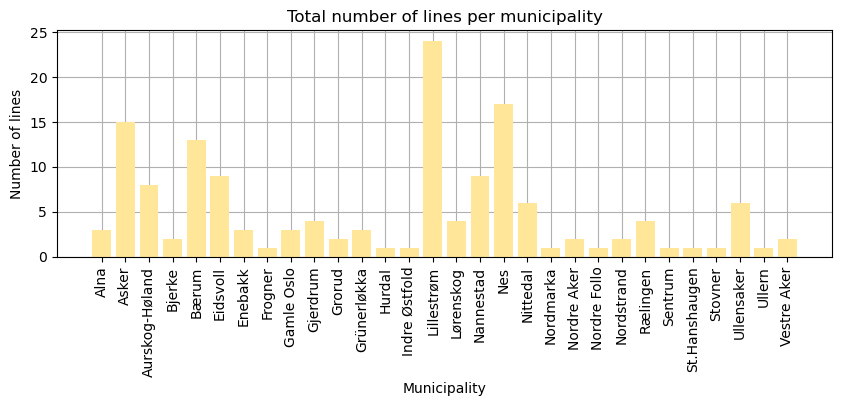

In [4]:
# create a figure and axis 

fig, ax = plt.subplots(figsize=(10,3), dpi=100)

# get x and y data 
x = komm_linje['Kommune']
y = komm_linje['Linjenavn']
plt.grid()
plt.bar(x, y, color='#ffe699')
plt.xticks(rotation=90)


# set title and labels 
ax.set_axisbelow(True)
ax.set_title('Total number of lines per municipality') 
ax.set_xlabel('Municipality') 
ax.set_ylabel('Number of lines')

<br><br><br>

## Feature 2 - Number of passengers per hour

In [7]:
passasjerer_per_time = pd.DataFrame(columns = ['Time Interval', 'No. of passengers'])

time_interval = []

for i in range(24):
    time_interval.append(str(i) + ':00 - ' + str(i) + ':59')

passasjerer_per_time['Time Interval'] = time_interval    
passenger_count = [0] * 24

for i in range(len(ruterData)):
    passenger_count[int(ruterData['Tidspunkt_Faktisk_Ankomst_Holdeplass_Fra'][i].split(':')[0])] += ruterData['Passasjerer_Ombord'][i]

passasjerer_per_time['No. of passengers'] = passenger_count
passasjerer_per_time

,Time Interval,No. of passengers
0,0:00 - 0:59,333
1,1:00 - 1:59,47
2,2:00 - 2:59,0
3,3:00 - 3:59,4
4,4:00 - 4:59,42
5,5:00 - 5:59,278
6,6:00 - 6:59,1071
7,7:00 - 7:59,2117
8,8:00 - 8:59,1805
9,9:00 - 9:59,994


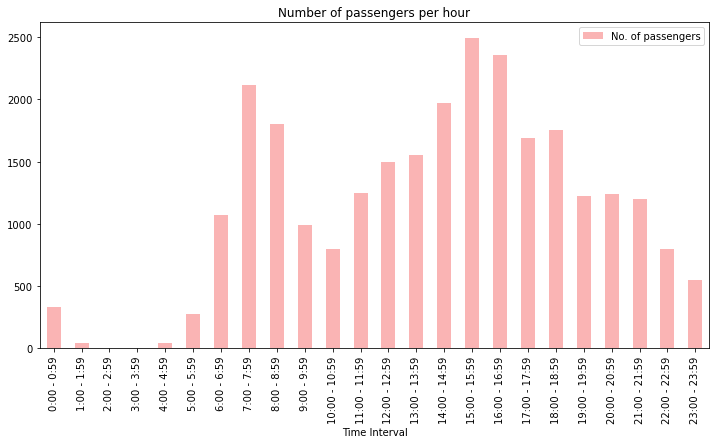

In [11]:
passasjerer_per_time.plot.bar(figsize=(12,6), title = 'Number of passengers per hour', x = 'Time Interval', y = 'No. of passengers', color = '#fab4b4')

<br><br><br>

## Feature 3 - Mean time for buses at a stop

In [12]:
stopTime = []
for i in range(len(ruterData)):
    avgang = pd.Timestamp(ruterData['Tidspunkt_Faktisk_Avgang_Holdeplass_Fra'][i])
    ankomst = pd.Timestamp(ruterData['Tidspunkt_Faktisk_Ankomst_Holdeplass_Fra'][i])
    stopTime.append((avgang - ankomst).seconds)
    
ruterData['Time_At_Stop'] = stopTime

line_name_mean = ruterData.groupby(['Linjenavn']).agg({'Time_At_Stop': ['mean']})
line_name_mean = line_name_mean['Time_At_Stop'].astype(int)
line_name_mean = line_name_mean.reset_index()
line_name_mean.rename(columns={"mean": "Buses Mean time at a stop {s}"})

,Linjenavn,Buses Mean time at a stop {s}
0,100,41
1,110,169
2,110E,59
3,115E,28
4,120,34
5,125E,21
6,130,23
7,140,25
8,140E,12
9,145,124


In [14]:
groupsLow = line_name_mean.drop(line_name_mean[line_name_mean['mean'] > 60].index)
groupsHigh = line_name_mean.drop(line_name_mean[line_name_mean['mean'] < 60].index)

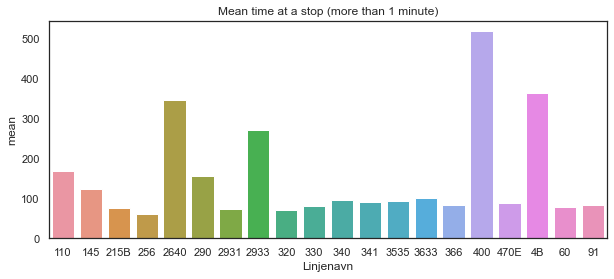

In [28]:
sns.set(rc={'figure.figsize':(10,4)})
sns.set_style('white')
ax = sns.barplot(x="Linjenavn", y="mean", data=groupsHigh).set_title('Mean time at a stop (more than 1 minute)')

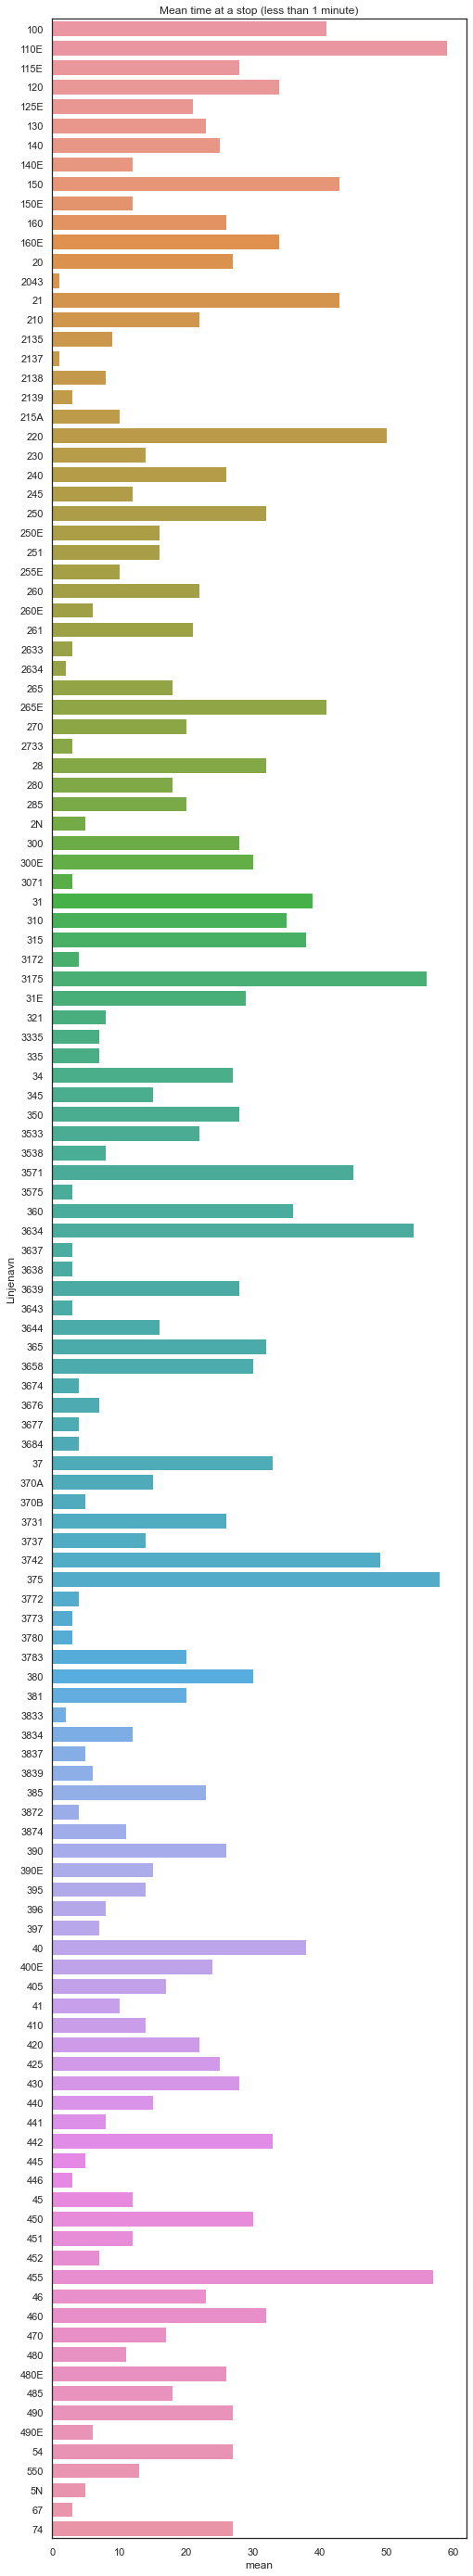

In [30]:
sns.set(rc={'figure.figsize':(8,50)})
sns.set_style('white')
ax = sns.barplot(y="Linjenavn", x="mean", data=groupsLow).set_title('Mean time at a stop (less than 1 minute)')

<br><br><br>

## Feature 4 - Capacities per busline

In [21]:
line_capacity = ruterData[['Linjenavn', 'Kjøretøy_Kapasitet']]
line_capacity.groupby('Linjenavn')['Kjøretøy_Kapasitet'].unique()

Linjenavn
100                  [151]
110                  [106]
110E            [115, 112]
115E                 [115]
120          [72, 76, 115]
125E              [76, 72]
130                  [130]
140                  [130]
140E             [69, 130]
145                  [130]
150                  [112]
150E                 [112]
160                  [112]
160E                 [112]
20                   [106]
2043                  [70]
21                   [106]
210                  [112]
2135                  [71]
2137                  [71]
2138                  [71]
2139                 [106]
215A             [69, 112]
215B                 [112]
220              [69, 112]
230                   [69]
240              [69, 112]
245              [69, 112]
250              [112, 80]
250E                 [112]
251                  [112]
255E                 [112]
256                  [112]
260             [112, 102]
260E                 [112]
261                  [112]
2633              

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


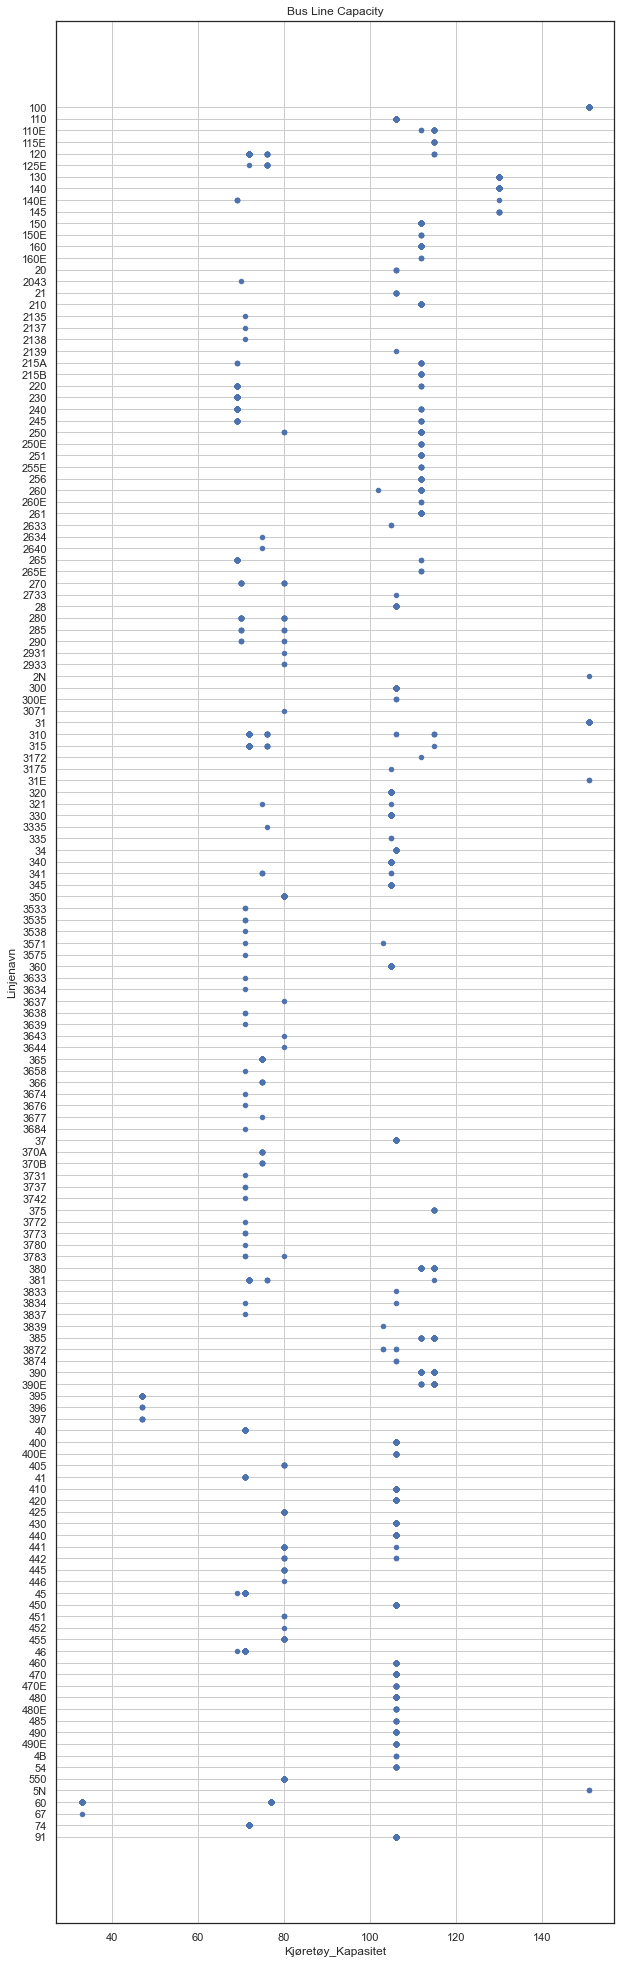

In [31]:
line_capacity.sort_values(by = 'Linjenavn', ascending = False).plot.scatter(figsize = (10,35), x='Kjøretøy_Kapasitet', y='Linjenavn', title='Bus Line Capacity', grid = True)

<br><br><br>

## Feature 5 - Number of times a line gets delayed

In [34]:
forsinketTid = []
for i in range(length):
    faktisk = pd.Timestamp(ruterData['Tidspunkt_Faktisk_Ankomst_Holdeplass_Fra'][i])
    planlagt = pd.Timestamp(ruterData['Tidspunkt_Planlagt_Ankomst_Holdeplass_Fra '][i])
    
    if(faktisk.time() > planlagt.time()):
        delta_tid = (faktisk - planlagt)
        forsinketTid.append(delta_tid.seconds)
    else:
        delta_tid = (planlagt - faktisk).seconds
        delta_tid = int("-" + str(delta_tid))
        forsinketTid.append(delta_tid)
        
#Add new column with delay times
ruterData['Forsinket_Ankomst_Tid'] = forsinketTid


#Finding indexes that satisfy the condition (1,5,10 minutes late)
oneMinute = ruterData[ ruterData['Forsinket_Ankomst_Tid'] > 60].index
fiveMinute = ruterData[ ruterData['Forsinket_Ankomst_Tid'] > 300].index
tenMinute = ruterData[ ruterData['Forsinket_Ankomst_Tid'] > 600].index

#adding all the rows that satisfy the condition
lineOneMinutes = []
for i in oneMinute:
    lineOneMinutes.append(ruterData.loc[i]['Linjenavn'])
        
lineFiveMinutes = []
for i in fiveMinute:
    lineFiveMinutes.append(ruterData.loc[i]['Linjenavn'])
    
lineTenMinutes = []
for i in tenMinute:
    lineTenMinutes.append(ruterData.loc[i]['Linjenavn'])

#### Creating dataframes of the lines with delays more than 1, 5, 10 minutes


In [35]:
lineOneMinutes = pd.Series(lineOneMinutes)
no_per_line1 = lineOneMinutes.value_counts().reset_index()
no_per_line1.columns = ['Line', 'No. of times late']

lineFiveMinutes = pd.Series(lineFiveMinutes)
no_per_line5 = lineFiveMinutes.value_counts().reset_index()
no_per_line5.columns = ['Line', 'No. of times late']

lineTenMinutes = pd.Series(lineTenMinutes)
no_per_line10 = lineTenMinutes.value_counts().reset_index()
no_per_line10.columns = ['Line', 'No. of times late']

#### Removing lines that were delayed less than 3 times. This is to reduce the size of plots

In [36]:
no_per_line1.drop(no_per_line1[no_per_line1['No. of times late'] < 3].index, inplace=True)
no_per_line5.drop(no_per_line5[no_per_line5['No. of times late'] < 3].index, inplace=True)

### Plots for delays more than 1 Minute, 5 Minutes, and 10 Minutes Respectively


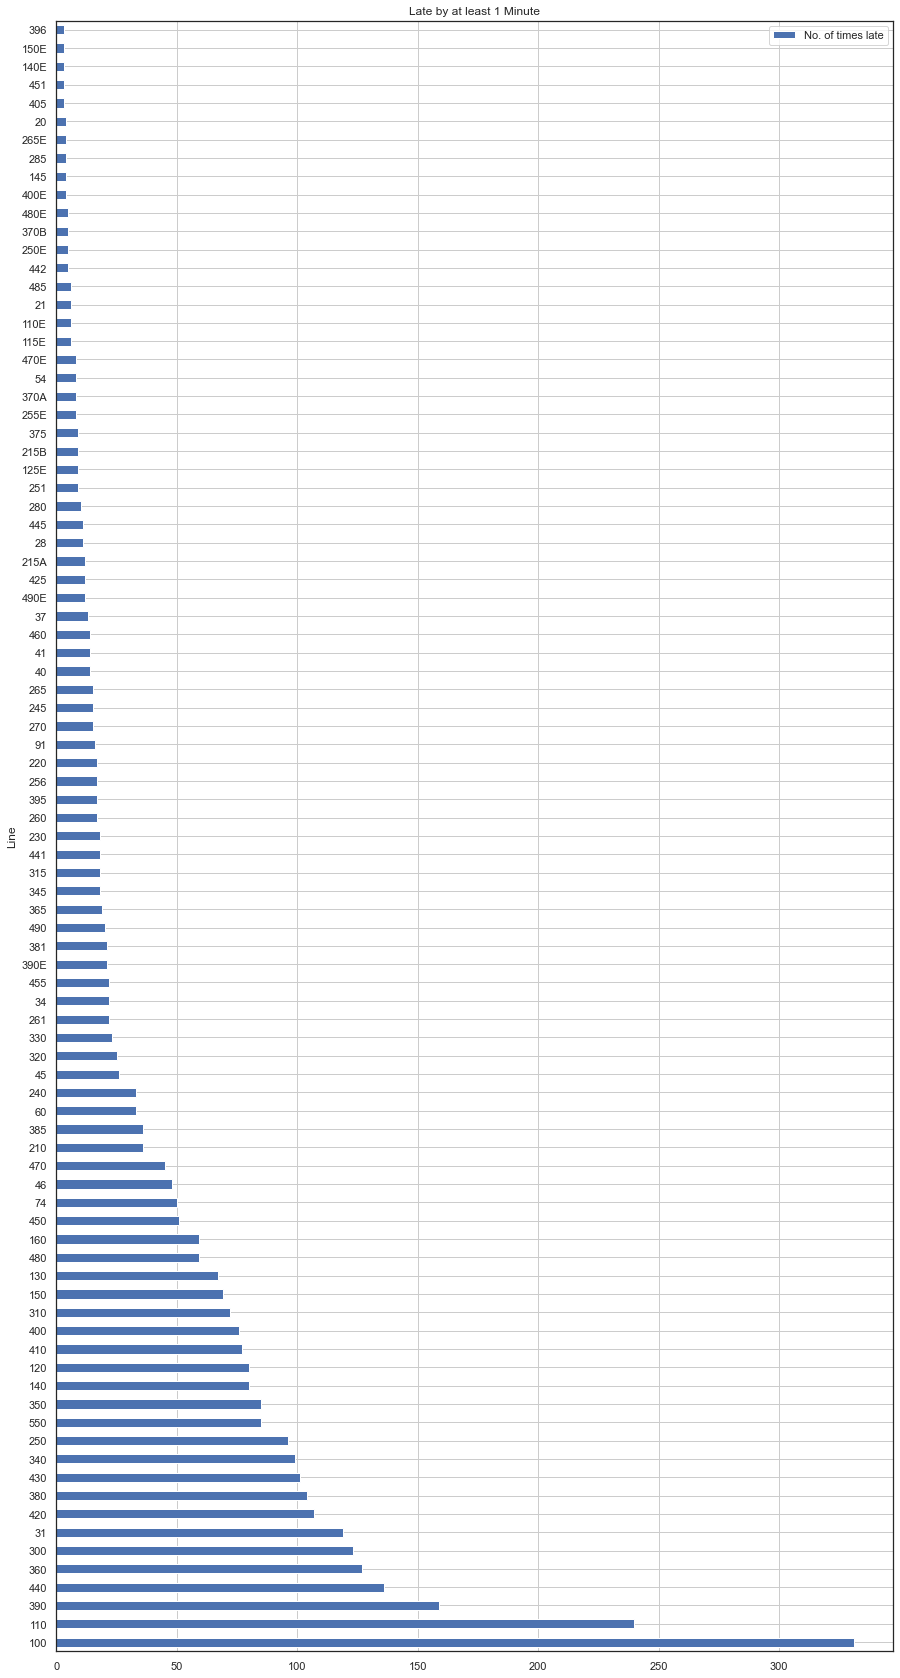

In [37]:
no_per_line1.plot.barh(figsize = (15, 30), x = 'Line', y = 'No. of times late', grid = True, title = 'Late by at least 1 Minute')

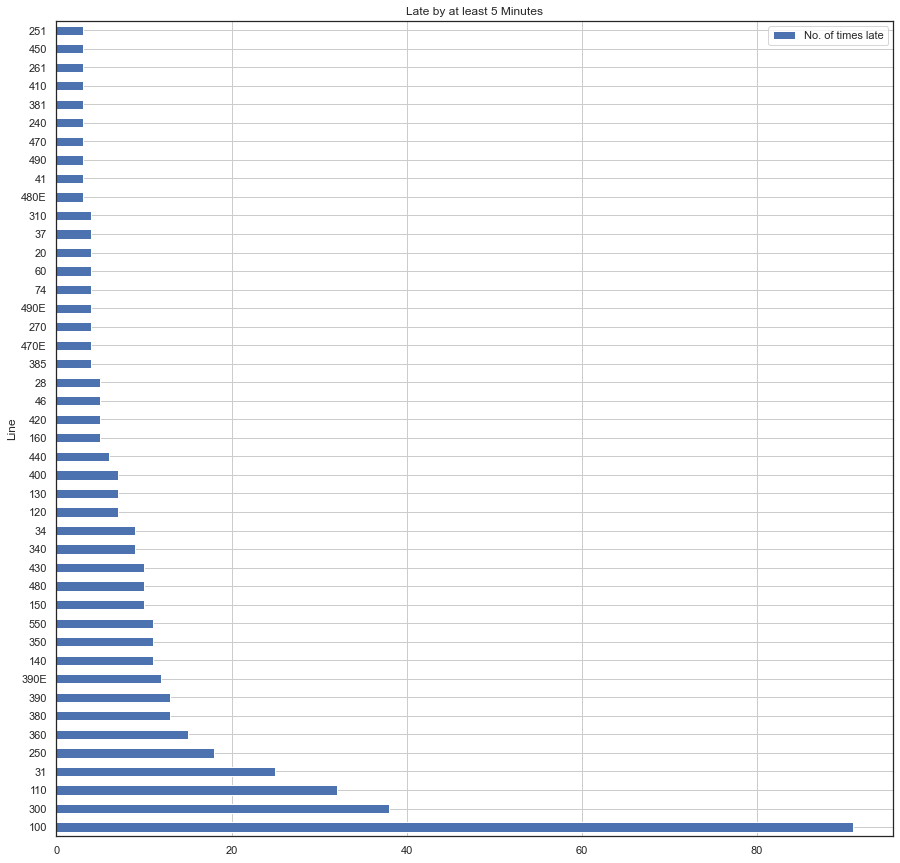

In [40]:
no_per_line5.plot.barh(figsize = (15, 15), x = 'Line', y = 'No. of times late', grid = True, title = 'Late by at least 5 Minutes')

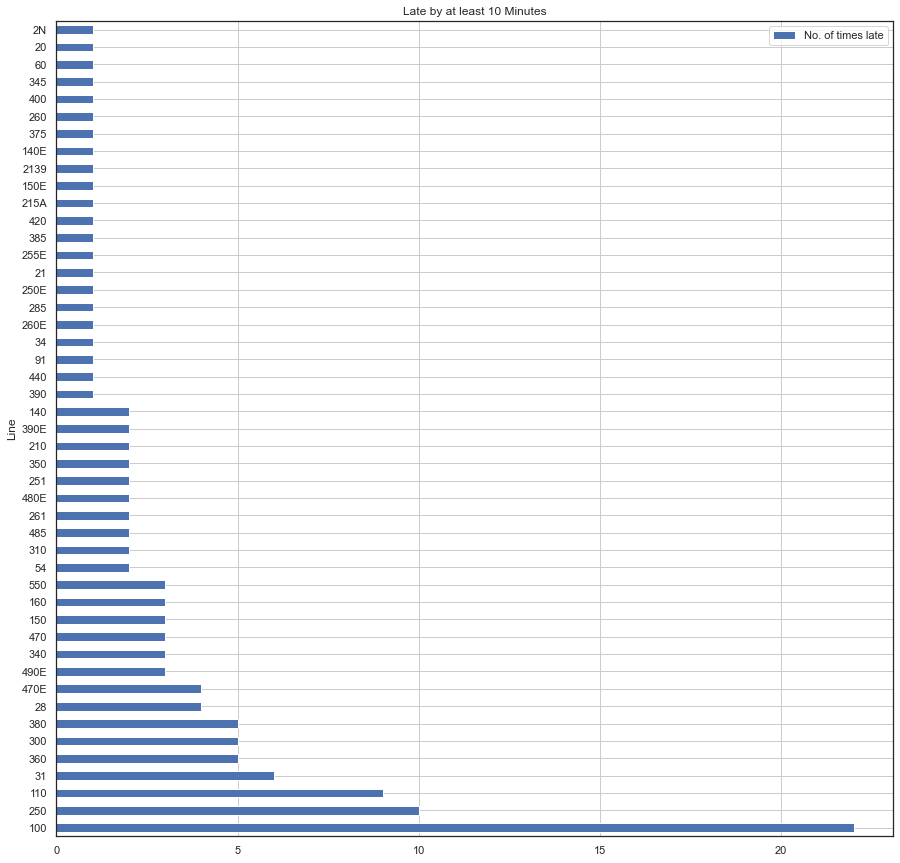

In [41]:
no_per_line10.plot.barh(figsize = (15, 15), x = 'Line', y = 'No. of times late', grid = True, title = 'Late by at least 10 Minutes')